In [1]:
import os
import sys
import numpy as np
import glob
import json

import matplotlib.pyplot as plt
import cv2
import random
import imageio

In [2]:
sys.path.append("add your path here")

import hl2ss
import hl2ss_3dcv
import utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def read_label_bbox(fp_l):
    # here fp is a list of path 
    # this function read the label of the object that specifies 2D object bounding box
    object_bbox = {}
    '''
        frame: {obj_id1: (x, y, w, h), obj_id2: (x, y, w, h)}
    '''
    for fp in fp_l:
        with open(fp, "r") as f:
            fname = fp.split("/")[-1]
            key_name = fname[-22:-4] # frame_xxxxx
            this_frame_object_bbox = {}
            for l in f:
                obj_id, x, y, w, h = l.split()
                this_frame_object_bbox[int(obj_id)] = np.array([x, y, w, h], dtype=np.float32) # in normalized format 
        object_bbox[key_name] = this_frame_object_bbox
    return object_bbox

## read data and labels

In [6]:
data_root = "your data root here"
raw_data_dir = "a video sequence"

raw_data_path = os.path.join(data_root, raw_data_dir)
annot_data_path = os.path.join(data_root, raw_data_dir.replace("raw", "annotation"))

In [ ]:
rgb_annot = glob.glob(os.path.join(annot_data_path, "pv", "*.txt"))
rgb_bbox = read_label_bbox(rgb_annot)

depth_annot = glob.glob(os.path.join(annot_data_path, "depth_ahat", "*.txt"))
depth_bbox = read_label_bbox(depth_annot)

## visualize annotations

In [25]:
# pick a frame 
select_f = "frame_140483674988"
select_obj = 2

# select_f = "frame_141319665654"
# select_obj = 3

Text(0.5, 1.0, 'AHAT Depth')

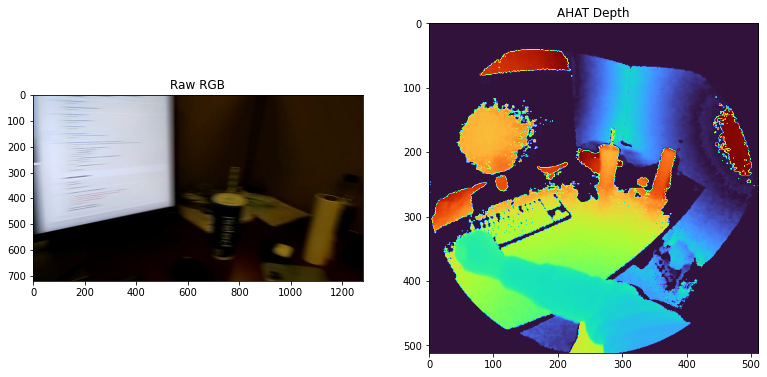

In [26]:
raw_rgb = imageio.imread(os.path.join(raw_data_path, "pv", select_f+".png"))

fig, axs = plt.subplots(1, 2, figsize=(13, 10))
axs[0].imshow(raw_rgb)
axs[0].set_title("Raw RGB")

raw_depth = cv2.imread(os.path.join(raw_data_path, "depth_ahat", select_f+".png"), cv2.IMREAD_UNCHANGED)

axs[1].imshow(raw_depth, cmap="turbo")
axs[1].set_title("AHAT Depth")

Text(0.5, 1.0, 'AHAT Depth')

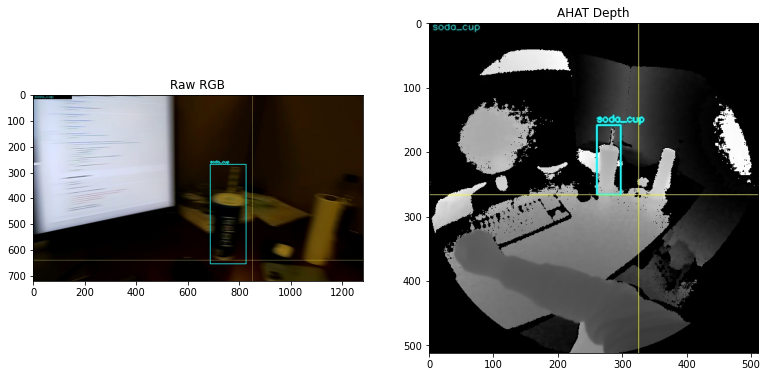

In [28]:
annot_rgb = imageio.imread(os.path.join(annot_data_path, "pv", "rgb_"+select_f+".jpg"))

fig, axs = plt.subplots(1, 2, figsize=(13, 10))
axs[0].imshow(annot_rgb)
axs[0].set_title("Raw RGB")

annot_depth = imageio.imread(os.path.join(annot_data_path, "depth_ahat", "depth_"+select_f+".jpg"))

axs[1].imshow(annot_depth, cmap="turbo")
axs[1].set_title("AHAT Depth")

## compute 3D pt

In [71]:
# load calibation info
calibration_path = "your calibration path here"

pv_calibration = utils._load_calibration_pv_yz(os.path.join(calibration_path, "personal_video"))
ahat_calibration = hl2ss_3dcv._load_calibration_rm_depth_ahat(os.path.join(calibration_path, "rm_depth_ahat"))
vlc_lf_calibration = hl2ss_3dcv._load_calibration_rm_vlc(os.path.join(calibration_path, "rm_vlc_leftfront"))

In [72]:
norm_depth_bbox = depth_bbox[select_f][select_obj] # xc, yc, wc, hc
depth_h, depth_w = raw_depth.shape[0], raw_depth.shape[1]

box = norm_depth_bbox[0:4] * np.array([depth_w, depth_h, depth_w, depth_h])
(centerX, centerY, width, height) = box.astype("int")
x = int(centerX - (width / 2))
y = int(centerY - (height / 2))

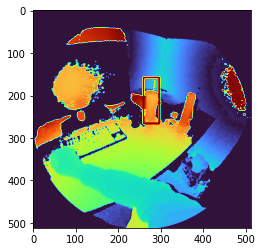

In [73]:
bbox_center = (centerX, centerY)

# visualize recovered bounding box
raw_depth_copy = raw_depth.copy()
cv2.rectangle(raw_depth_copy, (x,y), (x+width,y+height), (255, 255, 255), 3)
plt.imshow(raw_depth_copy, cmap='turbo')

In [74]:
uv2xy = ahat_calibration.uv2xy
xy1 = hl2ss_3dcv.to_homogeneous(uv2xy)
scale = np.linalg.norm(xy1, axis=2) * (ahat_calibration.scale / hl2ss.Parameters_RM_DEPTH_AHAT.FACTOR)

depth = raw_depth / scale
xyz = xy1 * depth[:, :, np.newaxis]
xyz1 = hl2ss_3dcv.to_homogeneous(xyz)

In [35]:
obj_3d = xyz[centerY, centerX]

## project 3D point to adjacent frames (as long as the object is not moving)

In [36]:
vlc_cam = "vlc_lf"

In [109]:
# load poses for rgb and depth cameras
rgb_pose = json.load(open(os.path.join(raw_data_path, "pv_pose.json"), "r"))
depth_pose = json.load(open(os.path.join(raw_data_path, "depth_ahat_pose.json"), "r"))
vlc_pose = json.load(open(os.path.join(raw_data_path, "vlc1_pose.json"), "r"))
 
# choose a target frame for projection
avail_frames = sorted(os.listdir(os.path.join(raw_data_path, "pv")))
source_idx = avail_frames.index(select_f+".png")
offset = 0
target_idx = source_idx + offset
 
target_frame = avail_frames[target_idx]
target_f = target_frame.split(".")[0]
print(target_f)
raw_target_depth = cv2.imread(os.path.join(raw_data_path, "depth_ahat", target_f+".png"), cv2.IMREAD_UNCHANGED)

# also opens a vlc camera for verifications
raw_target_vlc = cv2.imread(os.path.join(raw_data_path, vlc_cam, target_f+".png"), cv2.IMREAD_UNCHANGED)

frame_140483674988


Text(0.5, 1.0, 'Raw Target RGB')

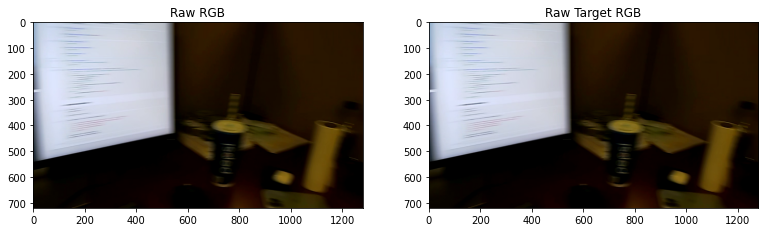

In [110]:
# visualize source and taget frame
fig, axs = plt.subplots(1, 2, figsize=(13, 10))
axs[0].imshow(raw_rgb)
axs[0].set_title("Raw RGB")

raw_target_rgb = imageio.imread(os.path.join(raw_data_path, "pv", target_frame))

axs[1].imshow(raw_target_rgb)
axs[1].set_title("Raw Target RGB")

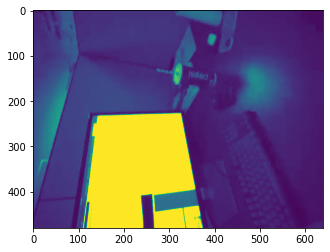

In [111]:
plt.imshow(raw_target_vlc)

## depth --> rgb

In [112]:
source_pose = depth_pose[select_f[-12:]]
target_pose = rgb_pose[target_f[-12:]]

In [113]:
ahat_to_pv_image = hl2ss_3dcv.camera_to_rignode(ahat_calibration.extrinsics) \
                   @ hl2ss_3dcv.reference_to_world(source_pose) \
                   @ hl2ss_3dcv.world_to_reference(target_pose) \
                   @ pv_calibration.intrinsics

uv, _ = hl2ss_3dcv.project_to_image(xyz1, ahat_to_pv_image)

proj_uv = uv[centerY, centerX]

In [115]:
new_d = np.zeros(raw_rgb.shape[:2])
u = uv[..., 0].astype(int).reshape(-1)
v = uv[..., 1].astype(int).reshape(-1)
keep = (u >= 0) & (u < raw_rgb.shape[1]) & (v >= 0) & (v < raw_rgb.shape[0])
new_d[v[keep], u[keep]] = xyz1.reshape(-1, 4)[keep][:, 2]

(29195, 4)


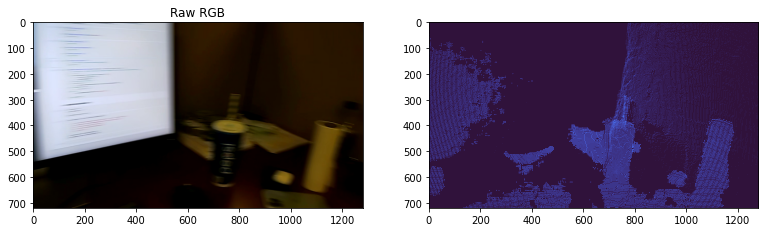

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(13, 10))
axs[0].imshow(raw_rgb)
axs[0].set_title("Raw RGB")

axs[1].imshow(new_d, cmap="turbo")

Text(0.5, 1.0, 'Raw Target RGB')

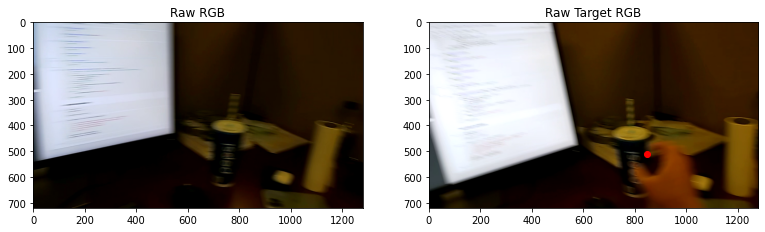

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(13, 10))
axs[0].imshow(raw_rgb)
axs[0].set_title("Raw RGB")

axs[1].imshow(raw_target_rgb)
axs[1].plot(uv[centerY, centerX][0], uv[centerY, centerX][1], marker='o', color="r")
axs[1].set_title("Raw Target RGB")

## depth --> depth

In [54]:
source_pose = depth_pose[select_f[-12:]]
target_pose = depth_pose[target_f[-12:]]

In [55]:
# depth to depth
ahat_to_ahat_image = hl2ss_3dcv.camera_to_rignode(ahat_calibration.extrinsics) \
                   @ hl2ss_3dcv.reference_to_world(source_pose) \
                   @ hl2ss_3dcv.world_to_reference(target_pose) \
                   @ hl2ss_3dcv.rignode_to_camera(ahat_calibration.extrinsics) @ ahat_calibration.intrinsics

uv, _ = hl2ss_3dcv.project_to_image(xyz1, ahat_to_ahat_image)

proj_uv = uv[centerY, centerX]

Text(0.5, 1.0, 'Raw Target Depth')

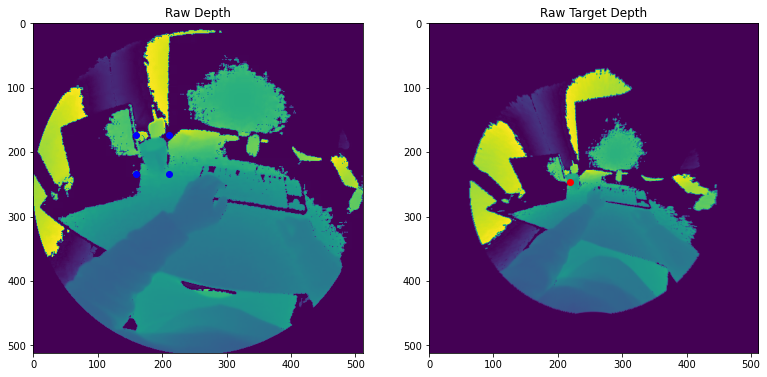

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(13, 10))
axs[0].imshow(raw_depth)

axs[0].plot(x, y, marker='o', color="b")
axs[0].plot(x, y+height, marker='o', color="b")
axs[0].plot(x+width, y, marker='o', color="b")
axs[0].plot(x+width, y+height, marker='o', color="b")

axs[0].set_title("Raw Depth")

axs[1].imshow(cv2.remap(raw_target_depth, ahat_calibration.undistort_map[:, :, 0], ahat_calibration.undistort_map[:, :, 1], cv2.INTER_LINEAR))
axs[1].plot(proj_uv[0], proj_uv[1], marker='o', color="r")

axs[1].set_title("Raw Target Depth")

## depth --> vlc_lf

In [57]:
source_pose = depth_pose[select_f[-12:]]
target_pose = vlc_pose[target_f[-12:]]

In [58]:
# depth to vlc 
ahat_to_vlc_image = hl2ss_3dcv.camera_to_rignode(ahat_calibration.extrinsics) \
                   @ hl2ss_3dcv.reference_to_world(source_pose) \
                   @ hl2ss_3dcv.world_to_reference(target_pose) \
                   @ hl2ss_3dcv.rignode_to_camera(vlc_lf_calibration.extrinsics) @ vlc_lf_calibration.intrinsics

uv, _ = hl2ss_3dcv.project_to_image(xyz1, ahat_to_vlc_image)

proj_uv = uv[centerY, centerX]

Text(0.5, 1.0, 'Raw Target Depth')

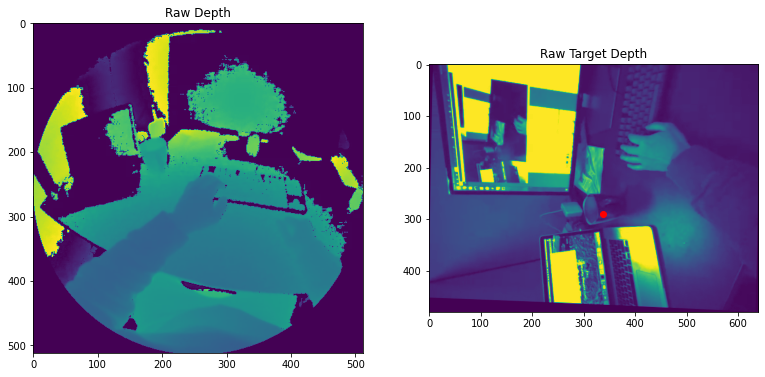

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(13, 10))
axs[0].imshow(raw_depth)
axs[0].set_title("Raw Depth")

# undistort vlc image to make it more accurate
axs[1].imshow(cv2.remap(raw_target_vlc, vlc_lf_calibration.undistort_map[:, :, 0], vlc_lf_calibration.undistort_map[:, :, 1], cv2.INTER_LINEAR))
axs[1].plot(proj_uv[0], proj_uv[1], marker='o', color="r")
axs[1].set_title("Raw Target Depth")